##### ATPA 2.6 - Missing and Extreme Values
###### For continuous and categorical variables in R, the mice package is useful (see pages 93-94)  https://cran.r-project.org/web/packages/mice/mice.pdf
###### Examples of autoimpute can be found at https://kearnz.github.io/autoimpute-tutorials

In [80]:
# Chunk 1: Prepares the flight data set for a permutation test

import pandas as pd
import numpy as np
import random
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import random

flights = pd.read_csv("Data/flights.csv")

# transforms the time variables to minutes from midnight. 
flights = flights.assign(dep_time= flights.dep_time-40*np.floor(flights.dep_time/100), sched_dep_time = flights.sched_dep_time-40*np.floor(flights.sched_dep_time/100))

In [2]:
display(flights.head(3))
flights.dep_time.describe() # recall that dep_time is hhmm for the time past midnight

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,Date
0,2013,1,1,317.0,315.0,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00,2013-01-01
1,2013,1,1,333.0,329.0,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00,2013-01-01
2,2013,1,1,342.0,340.0,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00,2013-01-01


count    328521.000000
mean        822.168169
std         292.730990
min           1.000000
25%         547.000000
50%         841.000000
75%        1064.000000
max        1440.000000
Name: dep_time, dtype: float64

In [3]:
flights.apply(lambda col: col.isna().sum())

year                 0
month                0
day                  0
dep_time          8255
sched_dep_time       0
dep_delay         8255
arr_time          8713
sched_arr_time       0
arr_delay         9430
carrier              0
flight               0
tailnum           2512
origin               0
dest                 0
air_time          9430
distance             0
hour                 0
minute               0
time_hour            0
Date                 0
dtype: int64

In [4]:
flights = flights.loc[:9, :]
flights.loc[8, 'dep_time'] = np.nan
display(flights)
flights.shape

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,Date
0,2013,1,1,317.0,315.0,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00,2013-01-01
1,2013,1,1,333.0,329.0,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00,2013-01-01
2,2013,1,1,342.0,340.0,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00,2013-01-01
3,2013,1,1,344.0,345.0,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01 05:00:00,2013-01-01
4,2013,1,1,354.0,360.0,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01 06:00:00,2013-01-01
5,2013,1,1,354.0,358.0,-4.0,740.0,728,12.0,UA,1696,N39463,EWR,ORD,150.0,719,5,58,2013-01-01 05:00:00,2013-01-01
6,2013,1,1,355.0,360.0,-5.0,913.0,854,19.0,B6,507,N516JB,EWR,FLL,158.0,1065,6,0,2013-01-01 06:00:00,2013-01-01
7,2013,1,1,357.0,360.0,-3.0,709.0,723,-14.0,EV,5708,N829AS,LGA,IAD,53.0,229,6,0,2013-01-01 06:00:00,2013-01-01
8,2013,1,1,NaN,360.0,-3.0,838.0,846,-8.0,B6,79,N593JB,JFK,MCO,140.0,944,6,0,2013-01-01 06:00:00,2013-01-01
9,2013,1,1,358.0,360.0,-2.0,753.0,745,8.0,AA,301,N3ALAA,LGA,ORD,138.0,733,6,0,2013-01-01 06:00:00,2013-01-01


(10, 20)

In [5]:
col_missing = 'dep_time'
col_base = 'sched_dep_time'

n = 100
R = np.zeros(n)
missing = flights.loc[:, col_missing].isna()
T = flights.loc[missing, col_base].mean() - flights.loc[~missing, col_base].mean()

for i in range(n):
    samp_i = flights.loc[:, col_missing].sample(frac=1., ignore_index=True)
    missing_i = samp_i.isna()
    R[i] = flights.loc[missing_i, col_base].mean() - flights.loc[~missing_i, col_base].mean()

R.mean()
np.quantile(R, [0.025, 0.5, 0.975])

array([-37.44444444,  10.33333333,  12.55555556])

In [26]:
class Permutation_Test:
    def __init__(self, data, col_missing, col_base):
        self.data = data
        self.col_missing = col_missing
        self.col_base = col_base
    
    def by_hand(self, quantile_lower, quantile_upper, n, return_R=False):
        missing = self.data.loc[:, self.col_missing].isna()
        T = self.data.loc[missing, self.col_base].mean() - self.data.loc[~missing, self.col_base].mean()

        R = np.zeros(n)
        for i in range(n):
            samp_i = self.data.loc[:, self.col_missing].sample(frac=1., ignore_index=True)
            missing_i = samp_i.isna()
            R[i] = self.data.loc[missing_i, self.col_base].mean() - self.data.loc[~missing_i, self.col_base].mean()

        if return_R:
            return {'T': np.round(T, 3),
                    'RMean': np.round(R.mean(), 3),
                    'RQuantiles': np.round(np.quantile(R, [quantile_lower, quantile_upper]), 3),
                    'T_InQuantiles': (T > quantile_lower) & (T < quantile_upper),
                    'R': R}
        else:
            return {'T': np.round(T, 3),
                    'RMean': np.round(R.mean(), 3),
                    'RQuantiles': np.round(np.quantile(R, [quantile_lower, quantile_upper]), 3),
                    'T_InQuantiles': (T > quantile_lower) & (T < quantile_upper)}

    def normal_approximation(self, quantile_percent):
        missing = self.data.loc[:, self.col_missing].isna()
        T = self.data.loc[missing, self.col_base].mean() - self.data.loc[~missing, self.col_base].mean()

        n = self.data.shape[0]
        m = self.data.loc[:,self.col_missing].isna().sum()
        v = np.var(self.data.loc[:, self.col_base])
        mean_R = 0
        var_R = n * v / (m*(n-m))

        u_bound = norm.ppf(quantile_percent, loc=mean_R, scale=np.sqrt(var_R))

        return {'T': np.round(T, 3),
                'RMean': mean_R,
                'RVar': np.round(var_R, 3),
                'RQuantiles': np.array([-u_bound, u_bound]),
                'T_InQuantiles': (T > -u_bound) & (T < u_bound)}


In [88]:
perm = Permutation_Test(data=flights, 
                        col_missing='dep_time', 
                        col_base='sched_dep_time')

perm.by_hand(quantile_lower=0.025,
             quantile_upper=0.975,
             n=1000,
             return_R=False)

perm.normal_approximation(quantile_percent=0.975)

{'T': 90.782,
 'RMean': 1.575,
 'RQuantiles': array([-2.961,  4.606]),
 'T_InQuantiles': False}

In [7]:
# Chunk 2: Performs a permutation test for the dep_time variable in the flights data set

# Find the test statistic for the data
is_missing = flights.dep_time.isnull()
Test_stat = flights.sched_dep_time.loc[is_missing].mean() - flights.sched_dep_time.loc[-is_missing].mean()
Test_stat

# Do a for loop to reorder the data, find the R values, and create a distribution to compare against the test statistic. The permutations are done on the variable that does not have missing value. That way the is_missing vector can be reused.
random.seed(1234)
nrun = 100
R_vals = [0 for i in range(nrun)]
ind = np.arange(len(flights))
for i in range(nrun):
  np.random.shuffle(ind)
  flights["temp_sched"] = flights.sched_dep_time[ind].reset_index().iloc[:,1]
  R_vals[i] =  flights.temp_sched[is_missing==True].mean() - flights.temp_sched.loc[is_missing==False].mean()

# Create a confidence interval
CI = np.quantile(R_vals,[.025,.975])
CI 

# Check condition
Test_stat < CI[1] and Test_stat > CI[0]

False

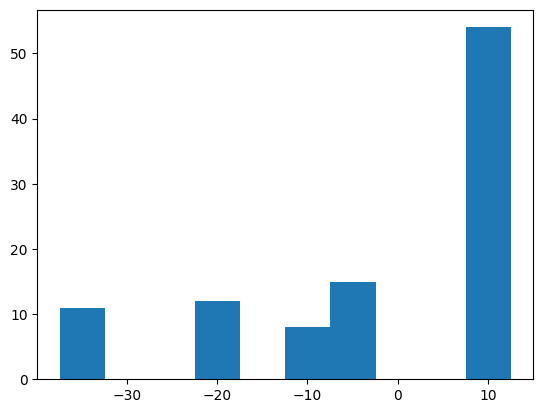

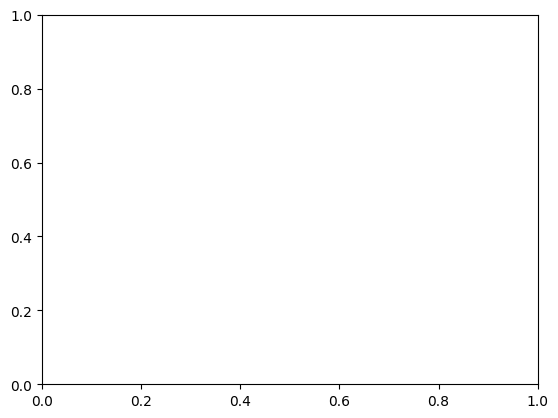

In [9]:
# Chunk 2A: Perform the permutation test using the normal approximation

import seaborn as sns
import matplotlib.pyplot as plt

n = flights.shape[0]
m = is_missing.sum()
v = flights.sched_dep_time.var()
var_R = n*v/m/(n-m)
CI2 = 1.96 * np.sqrt(var_R)
CI2
np.abs(Test_stat) < CI2


# The following are some additional checks on the approximation
# Calculate the variance of the sample of R-values and compare to the variance based on all permutations
np.var(R_vals)
var_R

# Make a simple histogram of the R-values
plt.hist(R_vals)
plt.show()
plt.cla()
# In this case the approximation worked well

In [73]:
# Chunk 3: Creates the production data set

# Create Data Set
production = pd.DataFrame({"Produced": [145,212,137,187,166],"Employees": [6,8,6,7,7],"Available_Machines":[19,24,np.nan,20,18],"Hours_Open":[10,9,8,9,6]})
production

,Produced,Employees,Available_Machines,Hours_Open
0,145,6,19.0,10
1,212,8,24.0,9
2,137,6,NaN,8
3,187,7,20.0,9
4,166,7,18.0,6


In [59]:
production.Available_Machines.isna()

0    False
1    False
2     True
3    False
4    False
Name: Available_Machines, dtype: bool

In [60]:
# production.loc[production.Available_Machines.isna(), "Available_Machines"] = production.loc[production.Available_Machines.notna(), "Available_Machines"].mean()

In [79]:
# x = production.loc[production.Available_Machines.notna(), :].drop(['Produced', 'Available_Machines'], axis=1)
# y = production.loc[production.Available_Machines.notna(), 'Available_Machines']
# mod = LinearRegression()
# mod_fit = mod.fit(x,y)
# mod_fit.predict(production.loc[production.Available_Machines.isna(), :].drop(['Produced', 'Available_Machines'], axis=1))

In [132]:
class ImputationMethods:
    def __init__(self, data):
        self.data = data
    
    def MeanImputation(self, col_to_impute):
        self.data.loc[self.data.loc[:, col_to_impute].isna(), col_to_impute] = self.data.loc[self.data.loc[:, col_to_impute].notna(), col_to_impute].mean()

        return self.data

    def RegressionImputation(self, col_to_impute, target_var):
        x = self.data.loc[self.data.loc[:, col_to_impute].notna(), :].drop([col_to_impute, target_var], axis=1)
        y = self.data.loc[self.data.loc[:, col_to_impute].notna(), col_to_impute]

        mod = LinearRegression().fit(x,y)
        self.data.loc[self.data.loc[:, col_to_impute].isna(), col_to_impute] = mod.predict(self.data.loc[self.data.loc[:, col_to_impute].isna(), :].drop([col_to_impute, target_var], axis=1))

        return self.data

    def KNNImputation_SingleVar(self, col_to_impute, target_var, n):
        x = self.data.loc[self.data.loc[:, col_to_impute].notna(), :].drop([col_to_impute, target_var], axis=1)
        y = self.data.loc[self.data.loc[:, col_to_impute].notna(), col_to_impute]

        mod = KNeighborsRegressor(n_neighbors=n).fit(x,y)
        self.data.loc[self.data.loc[:, col_to_impute].isna(), col_to_impute] = mod.predict(self.data.loc[self.data.loc[:, col_to_impute].isna(), :].drop([col_to_impute, target_var], axis=1))

        return self.data

    def CategoricalMeanImputation(self, col_to_impute):
        cnts = self.data.loc[:, col_to_impute].value_counts()

        na_count = self.data.loc[:, col_to_impute].isna().sum()
        samps = random.choices(population = cnts.index.values,
                                weights = cnts.values,
                                k = na_count)
        
        self.data.loc[self.data.loc[:, col_to_impute].isna(), col_to_impute] = samps
        return self.data


    

In [ ]:
production = pd.DataFrame({"Produced": [145,212,137,187,166],"Employees": [6,8,6,7,7],"Available_Machines":[19,24,np.nan,20,18],"Hours_Open":[10,9,8,9,6]})
prod_Impute = ImputationMethods(production.copy())
display(prod_Impute.MeanImputation('Available_Machines'))
prod_Impute = ImputationMethods(production.copy())
display(prod_Impute.RegressionImputation('Available_Machines', 'Produced'))
prod_Impute = ImputationMethods(production.copy())
display(prod_Impute.KNNImputation_SingleVar('Available_Machines', 'Produced', n=2))

,Produced,Employees,Available_Machines,Hours_Open
0,145,6,19.00,10
1,212,8,24.00,9
2,137,6,20.25,8
3,187,7,20.00,9
4,166,7,18.00,6


,Produced,Employees,Available_Machines,Hours_Open
0,145,6,19.000000,10
1,212,8,24.000000,9
2,137,6,16.808824,8
3,187,7,20.000000,9
4,166,7,18.000000,6


,Produced,Employees,Available_Machines,Hours_Open
0,145,6,19.0,10
1,212,8,24.0,9
2,137,6,19.5,8
3,187,7,20.0,9
4,166,7,18.0,6


In [138]:
production = pd.DataFrame({"Produced": [145,212,137,187,166],"Employees": [6,8,6,7,7],"Available_Machines":[19,24,np.nan,20,18],"Hours_Open":[10,9,8,9,6]})
production["Manager"] = ["On","Off","On","Off",np.nan]
prod_Impute = ImputationMethods(production.copy())
display(prod_Impute.CategoricalMeanImputation('Manager'))

,Produced,Employees,Available_Machines,Hours_Open,Manager
0,145,6,19.0,10,On
1,212,8,24.0,9,Off
2,137,6,NaN,8,On
3,187,7,20.0,9,Off
4,166,7,18.0,6,On


In [ ]:
# Chunk 4: Mean imputation

# using SingleImputer from the autoimpute package
# Warnings produced, if any, can be ignored

from autoimpute.imputations import SingleImputer, MultipleImputer

imp = SingleImputer(strategy={"Available_Machines":'mean'})
production_mean = imp.fit_transform(production)
production_mean

In [ ]:
# Chunk 5: Regression imputation

# using SingleImputer from the autoimpute package

imp = MultipleImputer(n=1,return_list=True,strategy={"Available_Machines":'least squares'})
# you can set n to a higher value if there is randomness in the imputation procedure and you want to see multiple versions, however, you do not need to 
# return_list=True is there so we can see the output
reg_imp = imp.fit_transform(production.drop(columns=["Produced"]))[0][1] # The output creates a nested structure and [0][1] helps us get the data frame
reg_imp

In [ ]:
# Chunk 5-optional: Do the above imputation manually

# Perform the regression
from sklearn.linear_model import LinearRegression
production_clean = production.loc[~pd.isna(production.Available_Machines),:]
display(production_clean)

X = production_clean.iloc[:,[1,3]].values.reshape(-1,2)
Y = production_clean.iloc[:,2].values.reshape(-1,1)
reg = LinearRegression().fit(X,Y)
reg.predict(np.array([[6,8]]))

,Produced,Employees,Available_Machines,Hours_Open
0,145,6,19.0,10
1,212,8,24.0,9
3,187,7,20.0,9
4,166,7,18.0,6


array([[16.80882353]])

In [ ]:
# Chunk 6: K Nearest Neighbors imputation

from sklearn.impute import KNNImputer

colnames = production.columns
imputer = KNNImputer(n_neighbors=2, weights="uniform")
pd.DataFrame(imputer.fit_transform(production.drop(columns=["Produced"])), columns = colnames[1:4])

,Employees,Available_Machines,Hours_Open
0,6.0,19.0,10.0
1,8.0,24.0,9.0
2,6.0,19.5,8.0
3,7.0,20.0,9.0
4,7.0,18.0,6.0


In [86]:
# Chunk 7: Imputing both categorical and numeric variables

production["Manager"] = ["On","Off","On","Off",np.nan]

imputer = SingleImputer(strategy={"Manager":"categorical"})
data_imputed = imputer.fit_transform(production)
data_imputed

# when using regression methods with mixed data types you need to binarize the categorical variables
newprod = pd.get_dummies(production.drop(columns=["Produced"]),drop_first=True)
imputer = MultipleImputer(return_list=True,n=1,strategy={"Available_Machines":"least squares","Manager_On":"binary logistic"})
data_imputed = imputer.fit_transform(newprod)[0][1]
data_imputed

# Note that the two imputation methods do not produce the same results for Manager

/home/mckayc/.pyenv/versions/3.9.6/envs/SOAModule_Notes/lib/python3.9/site-packages/autoimpute/utils/checks.py:110: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  n_ts = a.select_dtypes(include=(np.number, np.object))


AttributeError: module 'numpy' has no attribute 'object'

In [ ]:
# Chunk 8: Exercise 2.6.1 Check for Understanding Questions

import seaborn as sns
import matplotlib.pyplot as plt
# Read in autombile data set
Auto_Names = ["symboling", "normalized_losses", "make", "fuel_type","aspiration", "num_doors", "body_style", "drive_wheels","engine_location", "wheel_base", "length", "width", "height", "curb_weight", "engine_type","num_cylinders", "engine_size", "fuel_system", "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm", "city_mpg", "highway_mpg", "price"]

auto = pd.read_csv("automobile.csv",names=Auto_Names)
cols_to_keep = ["normalized_losses","num_doors","body_style","curb_weight","engine_type","bore","city_mpg","price"]
auto = auto[cols_to_keep]

# Replace ?'s with NAs
auto = auto.replace("?",np.nan)
# Change these three columns from character to numeric
auto = auto.assign(normalized_losses = [float(x) for x in auto.normalized_losses],bore = [float(x) for x in auto.bore],price = [float(x) for x in auto.price])

# Examine the normalized_loss variable for missingness at random.
# 1. Check a box plot for curb_weight and city_mpg when normalized_loss is and isn't missing

# 2. Perform a permutation test for the normalized_loss variable using curb_weight as the variable without missing data.

# 3. Explain the missingness of bore

# 4. Perform mean imputation for the missing values of price

# 5. Perform regression imputation for price

# 6. Perform imputation for both price and num_doors

In [ ]:
# Chunk 9A: Exercise 2.6.1: Question 1

import seaborn as sns
import matplotlib.pyplot as plt
# Read in autombile data set
Auto_Names = ["symboling", "normalized_losses", "make", "fuel_type","aspiration", "num_doors", "body_style", "drive_wheels","engine_location", "wheel_base", "length", "width", "height", "curb_weight", "engine_type","num_cylinders", "engine_size", "fuel_system", "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm", "city_mpg", "highway_mpg", "price"]

auto = pd.read_csv("automobile.csv",names=Auto_Names)
cols_to_keep = ["normalized_losses","num_doors","body_style","curb_weight","engine_type","bore","city_mpg","price"]
auto = auto[cols_to_keep]

# Replace ?'s with NAs
auto = auto.replace("?",np.nan)

# Convert numeric variables to numeric type
auto = auto.assign(normalized_losses = [float(x) for x in auto.normalized_losses],bore = [float(x) for x in auto.bore],price = [float(x) for x in auto.price])

# Examine the normalized_losses variable for missingness at random.
# 1. Check a box plot for curb_weight and city_mpg when normalized losses is and isn't missing
auto["missing"] = auto.normalized_losses.isnull()
sns.boxplot(x = "missing",y="curb_weight",data=auto)
plt.show()
plt.cla()
sns.boxplot(x = "missing",y="city_mpg",data=auto)
plt.show()
plt.cla()

# It seems as if there may be a relationship between missingness and both curb_weight city_mpg.

In [ ]:
# Chunk 9B: Exercise 2.6.1: Question 2

# 2. Perform a permutation test for the normalized_loss variable using curb_weight as the variable without missing data.
Test_stat = auto.curb_weight[auto.missing].mean()-auto.curb_weight[-auto.missing].mean()
Test_stat

# Do a for loop to reorder the data, find the R values, and create a distribution to compare against the test statistic
random.seed(1234)
nrun = 1000
R_vals = [0 for i in range(nrun)]
ind = np.arange(len(auto))
for i in range(nrun):
  np.random.shuffle(ind)
  auto["temp_curb_weight"] = auto.curb_weight[ind].reset_index().iloc[:,1]
  R_vals[i] = auto.temp_curb_weight[auto.missing].mean()-auto.temp_curb_weight[-auto.missing].mean()

# Create a confidence interval
CI = np.quantile(R_vals,[.025,.975])
CI 

# Check condition
Test_stat < CI[1] and Test_stat > CI[0]
# normalized_losses are not missing at random
auto = auto.drop(columns=["missing"])

In [ ]:
# Chunk 9C: Exercise 2.6.1: Question 3

# 3. Explain the missingness of bore with relationship to engine_type

# Look at the four records where bore is missing
pd.set_option('max_columns', None) # This will display all the columns
auto.loc[pd.isna(auto.bore),:]

# All have engine_type = rotor. Now check that this is the only time rotor appears
auto.loc[auto.engine_type == "rotor",:]

# When bore is missing, those are also the only incidences of the engine_type = rotor.
# At this point an investigation of this relationship might be in order. We will elect to delete these records, but that will imply any model we build will not be able to make predictions for cars with that engine_type.

auto = auto.loc[~pd.isna(auto.bore),:]

In [ ]:
# Chunk 9D: Exercise 2.6.1: Question 4

# 4. Perform mean imputation for the missing values of price. 

price_missing = auto.price.isnull()

imp = SingleImputer(strategy={"price":'mean'})
auto_mean = imp.fit_transform(auto)
auto_mean.loc[price_missing,"price"]

In [ ]:
# Chunk 9E: Exercise 2.6.1: Question 5

# 5. Perform regression imputation for the price

auto_dummies = pd.get_dummies(auto.drop(columns=["normalized_losses"]),drop_first=True)

imp = MultipleImputer(n=1,return_list=True,strategy={"price":'least squares'})
auto_reg = imp.fit_transform(auto_dummies)[0][1]
auto_reg.loc[price_missing,"price"]

In [ ]:
# Chunk 9F: Exercise 2.6.1: Question 6

# 6. Perform imputation for both price and num_doors.

doors_missing = auto.num_doors.isnull()

imp = MultipleImputer(n=1,return_list=True,strategy={"price":'least squares',"num_doors_two":'binary logistic'})
auto_reg_2 = imp.fit_transform(auto_dummies)[0][1]
auto_reg_2.loc[doors_missing,"num_doors_two"]
auto_reg_2.loc[price_missing,"price"]

In [ ]:
# Chunk 10: Identifying outliers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

hotel_bookings = pd.read_csv("hotel_bookings.csv")

# full data boxplot
sns.boxplot(y = "stays_in_week_nights",data=hotel_bookings)
plt.show()
plt.cla()

# full data histogram
sns.displot(hotel_bookings.stays_in_week_nights,binwidth=1)
plt.show()
plt.close()

In [ ]:
# Chunk 11: Looking for outliers

# Try cutoffs of 3, 5, and 10, 

cutoff = 5

hotel_trimmed = hotel_bookings.assign(zscores = (hotel_bookings.stays_in_week_nights-hotel_bookings.stays_in_week_nights.mean())/hotel_bookings.stays_in_week_nights.std())
hotel_trimmed = hotel_trimmed.loc[hotel_trimmed.zscores < cutoff,:]
100*(1 - len(hotel_trimmed.index)/len(hotel_bookings.index))
sns.displot(hotel_trimmed.stays_in_week_nights,binwidth=1)
plt.title("Trimmed at Zscores above " + str(cutoff))
plt.show()
plt.close()

In [ ]:
# ChunkS 12 - 15 Various methods to deal with outliers.
# Chunk 12: 1. Log transform
Because there are 0's, the transform is log(x+1)

hotel_log = hotel_bookings.assign(logstay = np.log(hotel_bookings.stays_in_week_nights+1))
sns.displot(hotel_log.logstay,binwidth=.5)
plt.title("Log Transformation")
plt.show()
plt.close()

In [ ]:
# Chunk 13: 2. Removing outliers. This is the same as in # Chunk 11. The cutoff in this example is a z-score of 5.

cutoff = 5
hotel_trimmed = hotel_bookings.assign(zscores = (hotel_bookings.stays_in_week_nights-hotel_bookings.stays_in_week_nights.mean())/hotel_bookings.stays_in_week_nights.std())
hotel_trimmed = hotel_trimmed.loc[hotel_trimmed.zscores < cutoff,:]
sns.displot(hotel_trimmed.stays_in_week_nights,binwidth=1)
plt.title("Trimmed at Zscores above " + str(cutoff))
plt.show()
plt.close()

In [ ]:
# Chunk 14: 3. Change the values. In this case we can cap all observations above 6 as being equal to 6. 

cap =  6
hotel_capped = hotel_bookings
hotel_capped.stays_in_week_nights = hotel_capped.stays_in_week_nights.clip(upper=cap)
sns.displot(hotel_capped.stays_in_week_nights,binwidth=1)
plt.title("Capped at "+str(cap))
plt.show()
plt.close()

In [ ]:
# Chunk 15: 4. Replace variable with percentiles.  

hotel_bookings = pd.read_csv("hotel_bookings.csv")

hotel_bookings["perc_stay"] = hotel_bookings.stays_in_week_nights.rank(pct=True)

plt.plot(hotel_bookings.stays_in_week_nights,hotel_bookings.perc_stay,"o")
plt.xlabel("Weeknight Stays",y="Percentiles")
plt.title("Percentile Transform by Raw Data")
plt.show() 
plt.close()

In [ ]:
# Chunk 16: Use DBSCAN to find outliers based on several observations. Change eps and minPts to affect the algorithm. The number of outliers are the number of noise points and given a cluster value of -1. 

from sklearn.cluster import DBSCAN
hotel_small = hotel_bookings.loc[:,["stays_in_week_nights","stays_in_weekend_nights","adults"]]
hotel_small = hotel_small.loc[0:9999,:]

eps = 3
minPts = 10
X = hotel_small.to_numpy()
clustering = DBSCAN(eps = eps, min_samples = minPts).fit(X)
cluster = pd.to_numeric(clustering.labels_)
cluster = pd.DataFrame(cluster, columns=["cluster"])
hotel_small2 = pd.concat([hotel_small,cluster],axis=1)
hotel_small2.query("cluster < 0")